<a href="https://colab.research.google.com/github/Yussefayman/Reinforcement-Learning/blob/main/BlackjackAgent.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [5]:
from collections import defaultdict
import gymnasium as gym
import numpy as np

In [6]:
class BlackjackAgent:
  def __init__(
      self,
      env: gym.Env,
      learning_rate: float,
      initial_epsilon: float,
      epsilon_decay: float,
      final_epsilon: float,
      discount_factor: float = 0.95,
  ):
    self.env = env
    self.q_values = defaultdict(lambda: np.zeros(env.action_space.n))
    self.lr = learning_rate
    self.discount_factor = discount_factor

    self.epsilon = initial_epsilon
    self.epsilon_decay = epsilon_decay
    self.final_epsilon = final_epsilon

    self.training_error = []

  def get_action(self, obs: tuple[int, int, bool]) -> int:
    if np.random.random() < self.epsilon:
      return self.env.action_space.sample()
    else:
      return int(np.argmax(self.q_values[obs]))

  def update(
      self,
      obs: tuple[int, int, bool],
      action: int,
      reward: float,
      terminated: bool,
      next_obs: tuple[int,int,bool],
  ):

    future_q_value = (not terminated) * np.max(self.q_values[next_obs])
    target = reward + self.discount_factor * future_q_value
    temporal_difference = target - self.q_values[obs][action]
    self.q_values[obs][action] = (
        self.q_values[obs][action] + self.lr * temporal_difference
    )
    self.training_error.append(temporal_difference)

  def decay_epsilon(self):
    self.epsilon = max(self.final_epsilon, self.epsilon - self.epsilon_decay)

In [7]:
learning_rate = 0.01
n_episodes = 100_000
start_epsilon = 1.0
epsilon_decay = start_epsilon / (n_episodes / 2)
final_epsilon = 0.1
env = gym.make("Blackjack-v1", sab=False)
env = gym.wrappers.RecordEpisodeStatistics(env,buffer_length = n_episodes)

agent = BlackjackAgent(
    env=env,
    learning_rate=learning_rate,
    initial_epsilon=start_epsilon,
    epsilon_decay=epsilon_decay,
    final_epsilon=final_epsilon
)

In [11]:
from tqdm import tqdm

for episode in tqdm(range(n_episodes)):
  obs, info = env.reset()
  done = False

  while not done:
    action = agent.get_action(obs)
    next_obs, reward, terminated, truncated, info = env.step(action)
    agent.update(obs,action,reward,terminated,next_obs)
    done = terminated or truncated
    obs = next_obs

  agent.decay_epsilon()

100%|██████████| 100000/100000 [00:17<00:00, 5695.15it/s]


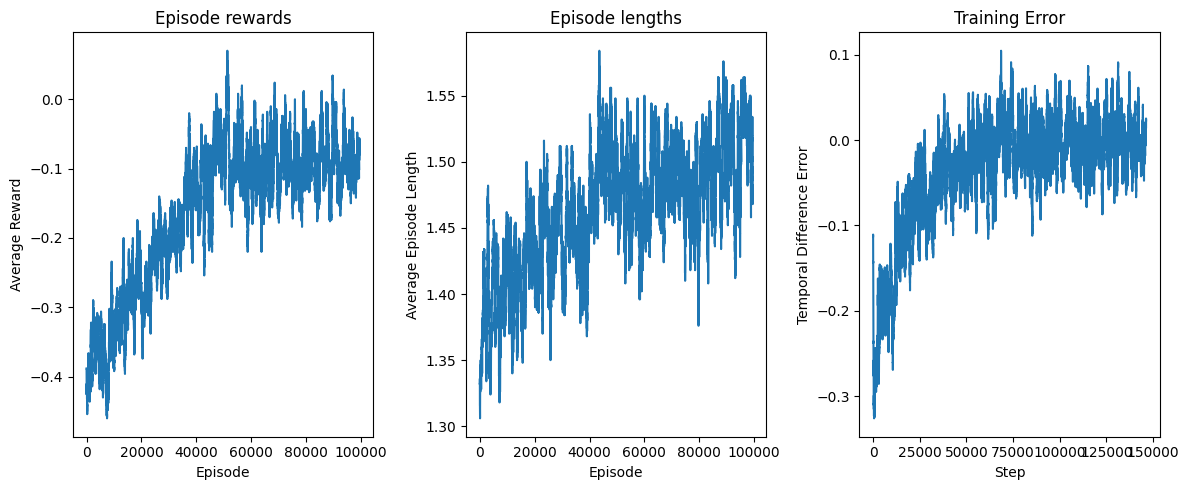

In [12]:
from matplotlib import pyplot as plt

def get_moving_avgs(arr, window, convolution_mode):
    """Compute moving average to smooth noisy data."""
    return np.convolve(
        np.array(arr).flatten(),
        np.ones(window),
        mode=convolution_mode
    ) / window

# Smooth over a 500-episode window
rolling_length = 500
fig, axs = plt.subplots(ncols=3, figsize=(12, 5))

# Episode rewards (win/loss performance)
axs[0].set_title("Episode rewards")
reward_moving_average = get_moving_avgs(
    env.return_queue,
    rolling_length,
    "valid"
)
axs[0].plot(range(len(reward_moving_average)), reward_moving_average)
axs[0].set_ylabel("Average Reward")
axs[0].set_xlabel("Episode")

# Episode lengths (how many actions per hand)
axs[1].set_title("Episode lengths")
length_moving_average = get_moving_avgs(
    env.length_queue,
    rolling_length,
    "valid"
)
axs[1].plot(range(len(length_moving_average)), length_moving_average)
axs[1].set_ylabel("Average Episode Length")
axs[1].set_xlabel("Episode")

# Training error (how much we're still learning)
axs[2].set_title("Training Error")
training_error_moving_average = get_moving_avgs(
    agent.training_error,
    rolling_length,
    "same"
)
axs[2].plot(range(len(training_error_moving_average)), training_error_moving_average)
axs[2].set_ylabel("Temporal Difference Error")
axs[2].set_xlabel("Step")

plt.tight_layout()
plt.show()

Training agent for 500000 episodes...


Training: 100%|██████████| 500000/500000 [02:19<00:00, 3584.89it/s]


Training completed!

Generating training visualizations...


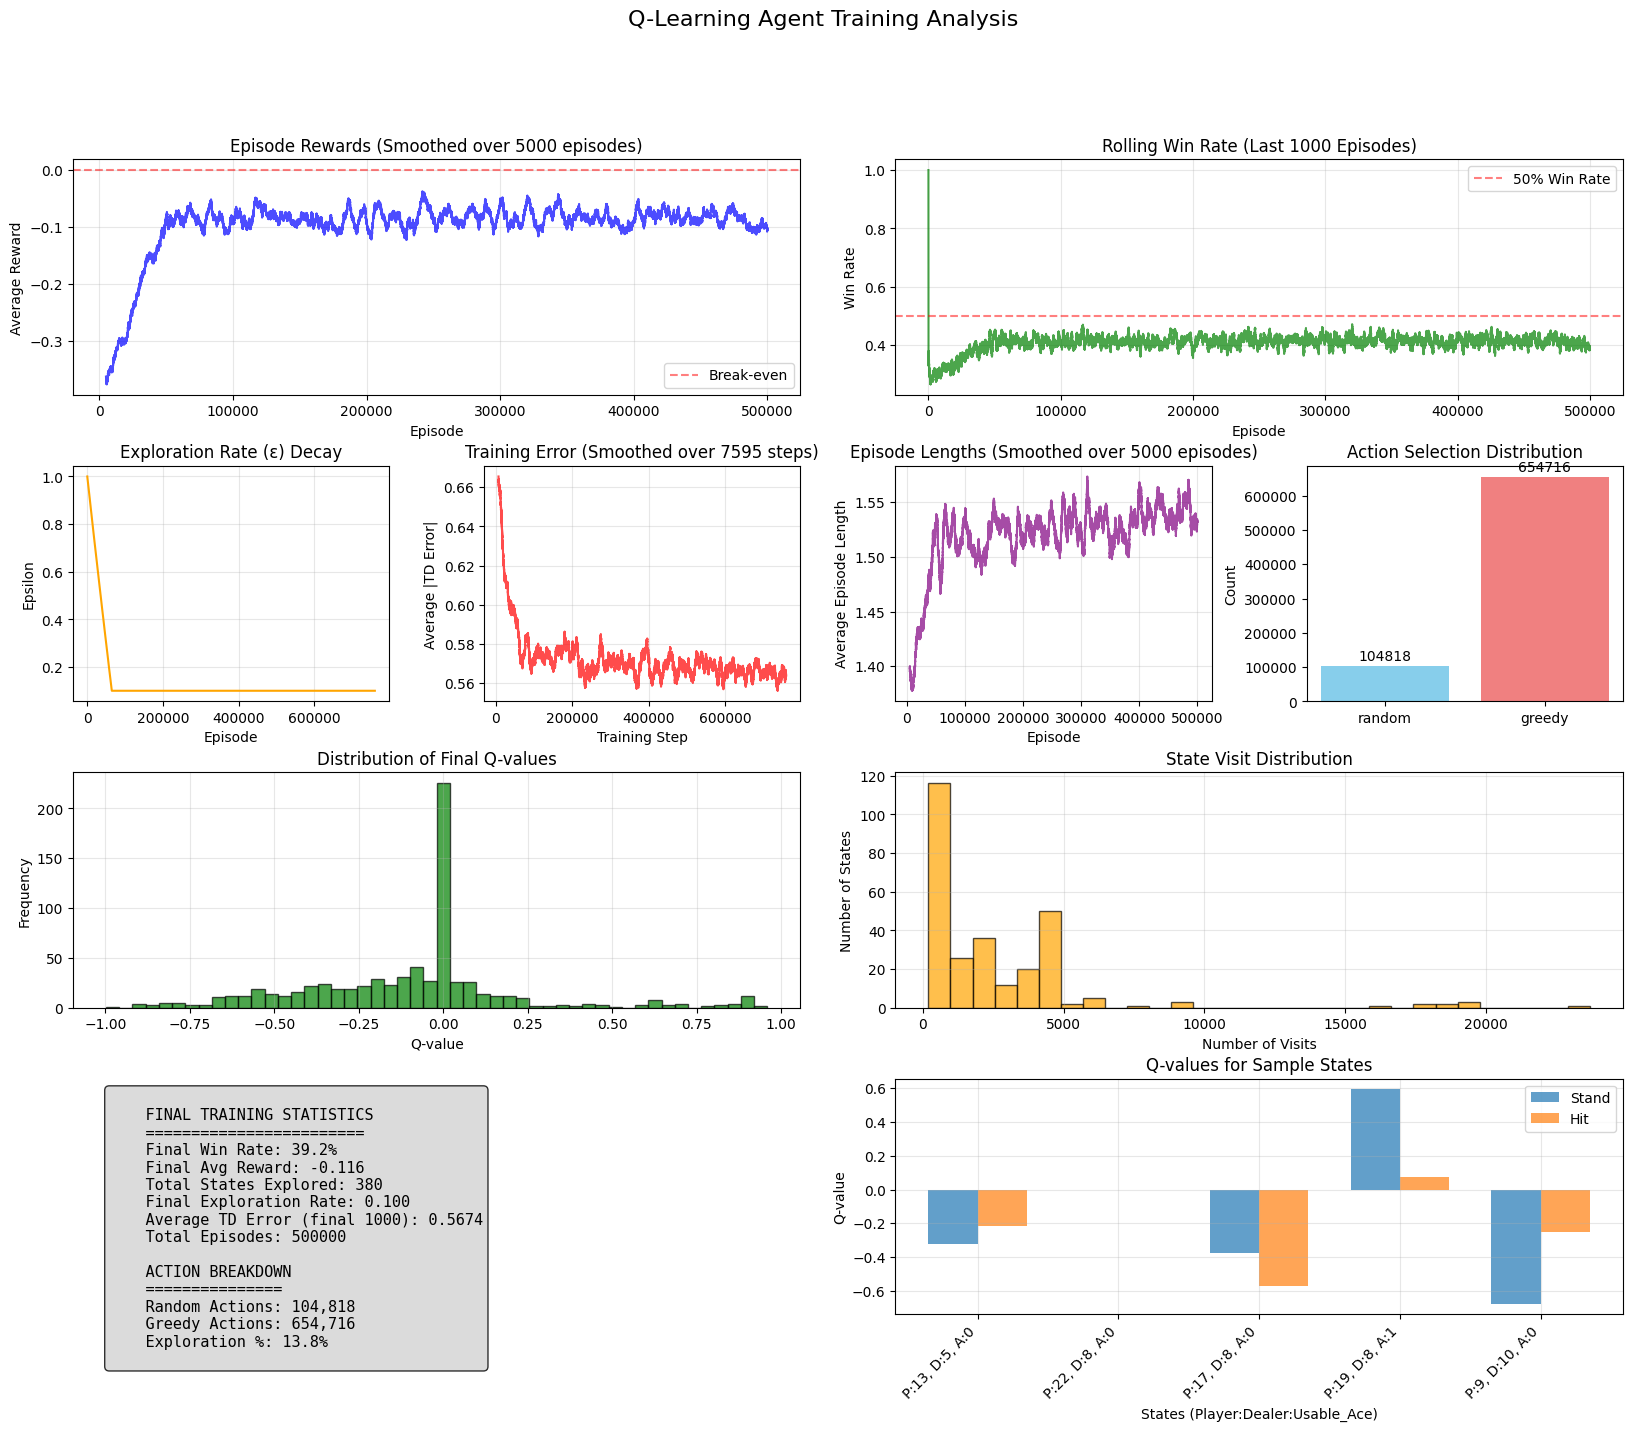


Generating policy and value visualizations...


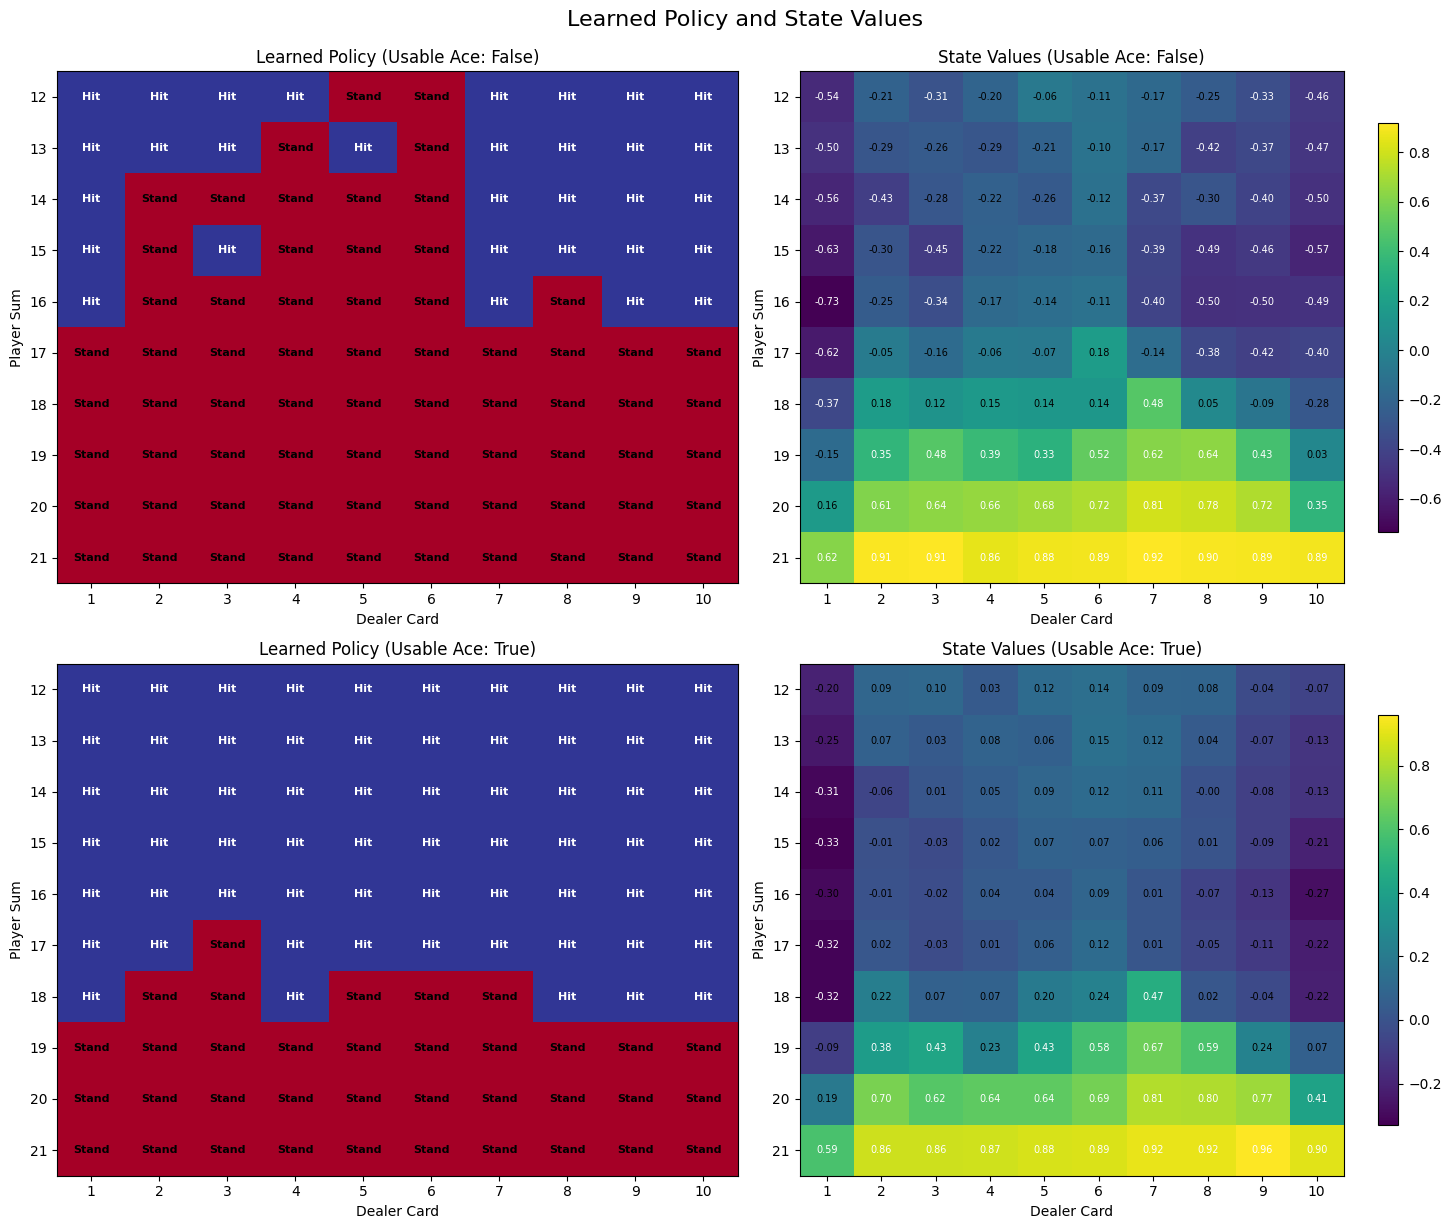


SCENARIO ANALYSIS: How does the agent play?

Weak hand vs weak dealer
State: Player=12, Dealer=2, Usable Ace=False
Q(Stand) = -0.326, Q(Hit) = -0.213
Decision: HIT (confidence: 0.113)
Times visited: 4310

Weak hand vs strong dealer
State: Player=12, Dealer=10, Usable Ace=False
Q(Stand) = -0.639, Q(Hit) = -0.460
Decision: HIT (confidence: 0.179)
Times visited: 17532

Dangerous hand vs strong dealer
State: Player=16, Dealer=10, Usable Ace=False
Q(Stand) = -0.640, Q(Hit) = -0.491
Decision: HIT (confidence: 0.149)
Times visited: 19094

Strong hand vs weak dealer
State: Player=20, Dealer=6, Usable Ace=False
Q(Stand) = 0.718, Q(Hit) = -0.737
Decision: STAND (confidence: 1.454)
Times visited: 4799

Soft 11 vs weak dealer
State: (11, 6, True) - Never encountered during training!

Soft 18 vs strong dealer
State: Player=18, Dealer=9, Usable Ace=True
Q(Stand) = -0.177, Q(Hit) = -0.042
Decision: HIT (confidence: 0.135)
Times visited: 749

BASIC STRATEGY COMPARISON
Basic Strategy recommendations:


Testing: 100%|██████████| 10000/10000 [00:01<00:00, 6298.76it/s]


Test Results:
Win Rate: 42.2%
Loss Rate: 48.0%
Draw Rate: 9.8%
Average Reward: -0.058
Average Episode Length: 1.6
Standard Deviation: 0.948


In [16]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict
import gymnasium as gym
from tqdm import tqdm
import pandas as pd
from matplotlib.animation import FuncAnimation
import warnings
warnings.filterwarnings('ignore')

class VisualBlackjackAgent:
    """
    Enhanced Q-Learning agent with detailed visualization capabilities
    """
    def __init__(self, env, learning_rate=0.01, initial_epsilon=1.0,
                 epsilon_decay=0.00001, final_epsilon=0.1, discount_factor=0.95):
        self.env = env
        self.q_values = defaultdict(lambda: np.zeros(env.action_space.n))
        self.lr = learning_rate
        self.discount_factor = discount_factor

        # Exploration parameters
        self.epsilon = initial_epsilon
        self.epsilon_decay = epsilon_decay
        self.final_epsilon = final_epsilon

        # Tracking metrics for visualization
        self.training_error = []
        self.episode_rewards = []
        self.episode_lengths = []
        self.epsilon_history = []
        self.q_value_changes = []
        self.win_rate_history = []
        self.action_counts = defaultdict(int)  # Track action frequency

        # State visit tracking
        self.state_visits = defaultdict(int)
        self.state_values = {}

    def get_action(self, obs, training=True):
        """Choose action with epsilon-greedy strategy"""
        if training:
            self.epsilon_history.append(self.epsilon)

        # Exploration vs Exploitation decision
        if training and np.random.random() < self.epsilon:
            action = self.env.action_space.sample()
            self.action_counts['random'] += 1
        else:
            action = int(np.argmax(self.q_values[obs]))
            self.action_counts['greedy'] += 1

        return action

    def update(self, obs, action, reward, terminated, next_obs):
        """Update Q-values and track learning progress"""
        # Track state visits
        self.state_visits[obs] += 1

        # Calculate target Q-value (Bellman equation)
        future_q_value = (not terminated) * np.max(self.q_values[next_obs])
        target = reward + self.discount_factor * future_q_value

        # Calculate temporal difference error
        current_q = self.q_values[obs][action]
        td_error = target - current_q

        # Update Q-value
        self.q_values[obs][action] = current_q + self.lr * td_error

        # Track changes for visualization
        self.training_error.append(abs(td_error))
        self.q_value_changes.append(self.lr * td_error)

        return td_error

    def decay_epsilon(self):
        """Reduce exploration rate"""
        self.epsilon = max(self.final_epsilon, self.epsilon - self.epsilon_decay)

    def get_state_value(self, obs):
        """Get the value of a state (max Q-value across actions)"""
        return np.max(self.q_values[obs]) if obs in self.q_values else 0

    def get_policy(self, obs):
        """Get the current policy (best action) for a state"""
        if obs not in self.q_values:
            return 0  # Default to Stand
        return int(np.argmax(self.q_values[obs]))

def train_agent_with_tracking(agent, n_episodes=500_000):
    """Train agent while collecting detailed metrics"""
    print(f"Training agent for {n_episodes} episodes...")

    recent_rewards = []  # For calculating rolling win rate

    for episode in tqdm(range(n_episodes), desc="Training"):
        obs, info = agent.env.reset()
        episode_reward = 0
        episode_length = 0
        done = False

        while not done:
            action = agent.get_action(obs, training=True)
            next_obs, reward, terminated, truncated, info = agent.env.step(action)

            # Learn from experience
            td_error = agent.update(obs, action, reward, terminated, next_obs)

            episode_reward += reward
            episode_length += 1
            done = terminated or truncated
            obs = next_obs

        # Record episode statistics
        agent.episode_rewards.append(episode_reward)
        agent.episode_lengths.append(episode_length)

        # Calculate rolling win rate (last 1000 episodes)
        recent_rewards.append(episode_reward > 0)
        if len(recent_rewards) > 1000:
            recent_rewards.pop(0)

        win_rate = np.mean(recent_rewards)
        agent.win_rate_history.append(win_rate)

        # Decay exploration rate
        agent.decay_epsilon()

    print("Training completed!")
    return agent

def visualize_training_progress(agent):
    """Create comprehensive visualization of training progress"""
    fig = plt.figure(figsize=(20, 15))

    # Create subplots
    gs = fig.add_gridspec(4, 4, hspace=0.3, wspace=0.3)

    # 1. Episode Rewards (smoothed)
    ax1 = fig.add_subplot(gs[0, 0:2])
    window_size = max(100, len(agent.episode_rewards) // 100)
    smoothed_rewards = pd.Series(agent.episode_rewards).rolling(window=window_size).mean()
    ax1.plot(smoothed_rewards, color='blue', alpha=0.7)
    ax1.axhline(y=0, color='red', linestyle='--', alpha=0.5, label='Break-even')
    ax1.set_title(f'Episode Rewards (Smoothed over {window_size} episodes)')
    ax1.set_xlabel('Episode')
    ax1.set_ylabel('Average Reward')
    ax1.legend()
    ax1.grid(True, alpha=0.3)

    # 2. Win Rate Over Time
    ax2 = fig.add_subplot(gs[0, 2:4])
    ax2.plot(agent.win_rate_history, color='green', alpha=0.7)
    ax2.axhline(y=0.5, color='red', linestyle='--', alpha=0.5, label='50% Win Rate')
    ax2.set_title('Rolling Win Rate (Last 1000 Episodes)')
    ax2.set_xlabel('Episode')
    ax2.set_ylabel('Win Rate')
    ax2.legend()
    ax2.grid(True, alpha=0.3)

    # 3. Epsilon Decay
    ax3 = fig.add_subplot(gs[1, 0])
    ax3.plot(agent.epsilon_history, color='orange')
    ax3.set_title('Exploration Rate (ε) Decay')
    ax3.set_xlabel('Episode')
    ax3.set_ylabel('Epsilon')
    ax3.grid(True, alpha=0.3)

    # 4. Training Error (Learning Progress)
    ax4 = fig.add_subplot(gs[1, 1])
    window_size_error = max(100, len(agent.training_error) // 100)
    smoothed_error = pd.Series(agent.training_error).rolling(window=window_size_error).mean()
    ax4.plot(smoothed_error, color='red', alpha=0.7)
    ax4.set_title(f'Training Error (Smoothed over {window_size_error} steps)')
    ax4.set_xlabel('Training Step')
    ax4.set_ylabel('Average |TD Error|')
    ax4.grid(True, alpha=0.3)

    # 5. Episode Lengths
    ax5 = fig.add_subplot(gs[1, 2])
    window_size_length = max(100, len(agent.episode_lengths) // 100)
    smoothed_lengths = pd.Series(agent.episode_lengths).rolling(window=window_size_length).mean()
    ax5.plot(smoothed_lengths, color='purple', alpha=0.7)
    ax5.set_title(f'Episode Lengths (Smoothed over {window_size_length} episodes)')
    ax5.set_xlabel('Episode')
    ax5.set_ylabel('Average Episode Length')
    ax5.grid(True, alpha=0.3)

    # 6. Action Distribution
    ax6 = fig.add_subplot(gs[1, 3])
    actions = list(agent.action_counts.keys())
    counts = list(agent.action_counts.values())
    colors = ['skyblue', 'lightcoral']
    ax6.bar(actions, counts, color=colors)
    ax6.set_title('Action Selection Distribution')
    ax6.set_ylabel('Count')
    for i, v in enumerate(counts):
        ax6.text(i, v + max(counts)*0.01, str(v), ha='center', va='bottom')

    # 7. Q-value Distribution
    ax7 = fig.add_subplot(gs[2, 0:2])
    all_q_values = []
    for state_q_values in agent.q_values.values():
        all_q_values.extend(state_q_values)

    ax7.hist(all_q_values, bins=50, alpha=0.7, color='green', edgecolor='black')
    ax7.set_title('Distribution of Final Q-values')
    ax7.set_xlabel('Q-value')
    ax7.set_ylabel('Frequency')
    ax7.grid(True, alpha=0.3)

    # 8. State Visit Frequency
    ax8 = fig.add_subplot(gs[2, 2:4])
    visit_counts = list(agent.state_visits.values())
    ax8.hist(visit_counts, bins=30, alpha=0.7, color='orange', edgecolor='black')
    ax8.set_title('State Visit Distribution')
    ax8.set_xlabel('Number of Visits')
    ax8.set_ylabel('Number of States')
    ax8.grid(True, alpha=0.3)

    # 9. Learning Statistics
    ax9 = fig.add_subplot(gs[3, 0:2])
    ax9.axis('off')

    # Calculate final statistics
    final_win_rate = np.mean([r > 0 for r in agent.episode_rewards[-1000:]])
    final_avg_reward = np.mean(agent.episode_rewards[-1000:])
    total_states_visited = len(agent.q_values)
    avg_td_error = np.mean(agent.training_error[-1000:])

    stats_text = f"""
    FINAL TRAINING STATISTICS
    ========================
    Final Win Rate: {final_win_rate:.1%}
    Final Avg Reward: {final_avg_reward:.3f}
    Total States Explored: {total_states_visited}
    Final Exploration Rate: {agent.epsilon:.3f}
    Average TD Error (final 1000): {avg_td_error:.4f}
    Total Episodes: {len(agent.episode_rewards)}

    ACTION BREAKDOWN
    ===============
    Random Actions: {agent.action_counts.get('random', 0):,}
    Greedy Actions: {agent.action_counts.get('greedy', 0):,}
    Exploration %: {agent.action_counts.get('random', 0) / sum(agent.action_counts.values()) * 100:.1f}%
    """

    ax9.text(0.05, 0.95, stats_text, transform=ax9.transAxes, fontsize=11,
             verticalalignment='top', fontfamily='monospace',
             bbox=dict(boxstyle='round', facecolor='lightgray', alpha=0.8))

    # 10. Q-value Evolution Sample
    ax10 = fig.add_subplot(gs[3, 2:4])

    # Show Q-values for a few interesting states
    sample_states = []
    for state in list(agent.q_values.keys())[:5]:  # First 5 states
        sample_states.append(state)

    if sample_states:
        state_labels = []
        q_values_stand = []
        q_values_hit = []

        for state in sample_states:
            state_labels.append(f"P:{state[0]}, D:{state[1]}, A:{state[2]}")
            q_values_stand.append(agent.q_values[state][0])  # Stand
            q_values_hit.append(agent.q_values[state][1])    # Hit

        x = np.arange(len(state_labels))
        width = 0.35

        ax10.bar(x - width/2, q_values_stand, width, label='Stand', alpha=0.7)
        ax10.bar(x + width/2, q_values_hit, width, label='Hit', alpha=0.7)

        ax10.set_title('Q-values for Sample States')
        ax10.set_xlabel('States (Player:Dealer:Usable_Ace)')
        ax10.set_ylabel('Q-value')
        ax10.set_xticks(x)
        ax10.set_xticklabels(state_labels, rotation=45, ha='right')
        ax10.legend()
        ax10.grid(True, alpha=0.3)

    plt.suptitle('Q-Learning Agent Training Analysis', fontsize=16, y=0.98)
    plt.show()

def visualize_policy_and_values(agent):
    """Visualize the learned policy and state values"""
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))

    # Create matrices for visualization
    # We'll show policy for usable_ace=True and usable_ace=False

    for ace_idx, usable_ace in enumerate([False, True]):
        # Policy visualization
        ax_policy = axes[ace_idx, 0]
        # Value visualization
        ax_value = axes[ace_idx, 1]

        # Create matrices (player_sum from 12-21, dealer_card from 1-10)
        policy_matrix = np.zeros((10, 10))  # 10 player sums × 10 dealer cards
        value_matrix = np.zeros((10, 10))

        for player_sum in range(12, 22):  # 12-21
            for dealer_card in range(1, 11):  # 1-10
                state = (player_sum, dealer_card, usable_ace)

                # Get policy (0=Stand, 1=Hit)
                if state in agent.q_values:
                    policy = np.argmax(agent.q_values[state])
                    value = np.max(agent.q_values[state])
                else:
                    policy = 0  # Default to Stand
                    value = 0

                policy_matrix[player_sum - 12, dealer_card - 1] = policy
                value_matrix[player_sum - 12, dealer_card - 1] = value

        # Plot policy
        im1 = ax_policy.imshow(policy_matrix, cmap='RdYlBu', aspect='auto')
        ax_policy.set_title(f'Learned Policy (Usable Ace: {usable_ace})')
        ax_policy.set_xlabel('Dealer Card')
        ax_policy.set_ylabel('Player Sum')
        ax_policy.set_xticks(range(10))
        ax_policy.set_xticklabels(range(1, 11))
        ax_policy.set_yticks(range(10))
        ax_policy.set_yticklabels(range(12, 22))

        # Add text annotations for policy
        for i in range(10):
            for j in range(10):
                action = 'Hit' if policy_matrix[i, j] == 1 else 'Stand'
                ax_policy.text(j, i, action, ha='center', va='center',
                              color='white' if policy_matrix[i, j] == 1 else 'black',
                              fontsize=8, weight='bold')

        # Plot values
        im2 = ax_value.imshow(value_matrix, cmap='viridis', aspect='auto')
        ax_value.set_title(f'State Values (Usable Ace: {usable_ace})')
        ax_value.set_xlabel('Dealer Card')
        ax_value.set_ylabel('Player Sum')
        ax_value.set_xticks(range(10))
        ax_value.set_xticklabels(range(1, 11))
        ax_value.set_yticks(range(10))
        ax_value.set_yticklabels(range(12, 22))

        # Add colorbar for values
        plt.colorbar(im2, ax=ax_value, shrink=0.8)

        # Add text annotations for values
        for i in range(10):
            for j in range(10):
                value = value_matrix[i, j]
                ax_value.text(j, i, f'{value:.2f}', ha='center', va='center',
                             color='white' if abs(value) > 0.3 else 'black',
                             fontsize=7)

    plt.tight_layout()
    plt.suptitle('Learned Policy and State Values', fontsize=16, y=1.02)
    plt.show()

def analyze_specific_scenarios(agent):
    """Analyze how the agent behaves in specific game scenarios"""
    print("\n" + "="*60)
    print("SCENARIO ANALYSIS: How does the agent play?")
    print("="*60)

    scenarios = [
        ((12, 2, False), "Weak hand vs weak dealer"),
        ((12, 10, False), "Weak hand vs strong dealer"),
        ((16, 10, False), "Dangerous hand vs strong dealer"),
        ((20, 6, False), "Strong hand vs weak dealer"),
        ((11, 6, True), "Soft 11 vs weak dealer"),
        ((18, 9, True), "Soft 18 vs strong dealer"),
    ]

    for state, description in scenarios:
        if state in agent.q_values:
            q_stand = agent.q_values[state][0]
            q_hit = agent.q_values[state][1]
            action = "HIT" if q_hit > q_stand else "STAND"
            confidence = abs(q_hit - q_stand)

            print(f"\n{description}")
            print(f"State: Player={state[0]}, Dealer={state[1]}, Usable Ace={state[2]}")
            print(f"Q(Stand) = {q_stand:.3f}, Q(Hit) = {q_hit:.3f}")
            print(f"Decision: {action} (confidence: {confidence:.3f})")
            print(f"Times visited: {agent.state_visits.get(state, 0)}")
        else:
            print(f"\n{description}")
            print(f"State: {state} - Never encountered during training!")

def compare_with_basic_strategy():
    """Show basic strategy recommendations for comparison"""
    print("\n" + "="*60)
    print("BASIC STRATEGY COMPARISON")
    print("="*60)
    print("Basic Strategy recommendations:")
    print("- Hit on 12-16 against dealer 7-A")
    print("- Stand on 12-16 against dealer 2-6")
    print("- Always hit on 11 or less")
    print("- Always stand on 17 or more")
    print("- Double on 11 against dealer 2-10")
    print("- Soft hands: Hit soft 17 or less, stand on soft 18+")

def test_trained_agent(agent, n_test_episodes=10000):
    """Test the trained agent's performance"""
    print(f"\nTesting trained agent over {n_test_episodes} episodes...")

    # Disable exploration for testing
    old_epsilon = agent.epsilon
    agent.epsilon = 0.0

    test_rewards = []
    test_lengths = []

    for _ in tqdm(range(n_test_episodes), desc="Testing"):
        obs, _ = agent.env.reset()
        episode_reward = 0
        episode_length = 0
        done = False

        while not done:
            action = agent.get_action(obs, training=False)
            obs, reward, terminated, truncated, info = agent.env.step(action)
            episode_reward += reward
            episode_length += 1
            done = terminated or truncated

        test_rewards.append(episode_reward)
        test_lengths.append(episode_length)

    # Restore epsilon
    agent.epsilon = old_epsilon

    # Calculate statistics
    win_rate = np.mean([r > 0 for r in test_rewards])
    loss_rate = np.mean([r < 0 for r in test_rewards])
    draw_rate = np.mean([r == 0 for r in test_rewards])
    avg_reward = np.mean(test_rewards)
    avg_length = np.mean(test_lengths)

    print(f"\nTest Results:")
    print(f"Win Rate: {win_rate:.1%}")
    print(f"Loss Rate: {loss_rate:.1%}")
    print(f"Draw Rate: {draw_rate:.1%}")
    print(f"Average Reward: {avg_reward:.3f}")
    print(f"Average Episode Length: {avg_length:.1f}")
    print(f"Standard Deviation: {np.std(test_rewards):.3f}")

# Main execution
if __name__ == "__main__":
    # Create environment
    env = gym.make("Blackjack-v1", sab=False)

    # Create agent with visualization capabilities
    agent = VisualBlackjackAgent(
        env=env,
        learning_rate=0.01,
        initial_epsilon=1.0,
        epsilon_decay=0.00002,  # Slower decay for better exploration
        final_epsilon=0.1,
        discount_factor=0.95
    )

    # Train the agent
    trained_agent = train_agent_with_tracking(agent, n_episodes=500_000)

    # Create comprehensive visualizations
    print("\nGenerating training visualizations...")
    visualize_training_progress(trained_agent)

    print("\nGenerating policy and value visualizations...")
    visualize_policy_and_values(trained_agent)

    # Analyze specific scenarios
    analyze_specific_scenarios(trained_agent)

    # Compare with basic strategy
    compare_with_basic_strategy()

    # Test final performance
    test_trained_agent(trained_agent)
